# Determining the Tradeoff

### Introduction

Over the last couple of lessons, we've seen that there is a tradeoff between recall and precision.  This tradeoff makes sense.  The wider a net we cast, thus increasing the recall, the lower our precision as our false positives increase.  

In this lesson, we'll make this tradeoff more explicit.  And we'll see how we can alter our machine learning model depending on the balance we wish to strike.

### Loading the data

Let's continue with our customer churn dataset.  We can begin by loading our data and training a machine learning model.

In [1]:
import pandas as pd
url = "https://raw.githubusercontent.com/jigsawlabs-student/logistic-regression/master/0-classification-fundamentals/3-metrics-for-classification/coerced_customer_churn.csv"
df = pd.read_csv(url, index_col = 0)

X = df.drop('Churn', axis = 1)
y = df['Churn']

In [61]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [62]:
X_df = pd.DataFrame(data = X_scaled, columns = X.columns)

In [63]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_df, y,
                                                    test_size = .4,
                                                    random_state = 1)
X_validate, X_test, y_validate, y_test = train_test_split(X_test, y_test, 
                                                          test_size = .5,
                                                          random_state = 1)

In [64]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver = "lbfgs",
                           max_iter = 5000, class_weight = 'balanced',
                           random_state = 1).fit(X_train, y_train)

In [66]:
model.score(X_validate, y_validate)

0.7615330021291696

### Modifying the Threshold

In [67]:
from sklearn.metrics import precision_score, recall_score

In [69]:
recall_score(y_validate, model.predict(X_validate)), precision_score(y_validate, model.predict(X_validate))

(0.8060941828254847, 0.5224416517055656)

Now, let's try to improve our recall score, and thus detect more customers who will churn, by lowering our threshold for making a positive prediction.  We can do so, predicting those with a `prob_a` score of only .40 to be positive.  This will have our model cast a wider net, by including observations that previously did not meet the threshold to be declared positive.

In [70]:
threshold = .4

threshold_preds = (model.predict_proba(X_validate) > threshold)[:, 1]
threshold_preds[:3]

array([ True,  True,  True])

So above we simply check if the score is above our threshold of `.4`.  Those. that are above .4 are now declared positive.  Doing so should now increase our recall score, and decrease our precision score.  Let's see it.

In [71]:
recall_score(y_validate, threshold_preds), precision_score(y_validate, threshold_preds)

(0.9168975069252078, 0.47763347763347763)

And it did.  We now capture 91 percent of the positive observations, but over half of the observations that we capture are false positives. Depending on the business goals -- perhaps it's worth it to still give more customers a call -- this may be ok.

### Plotting Precision and Recall Scores

Having the ability to balance precision and recall is a really practical skill.  For example, in this example, we don't want customers to churn, but there's also a cost to any efforts (like a discount) to retain them.

This balancing act is made easier with the use of the `precision_recall_curve` function provided by sklearn.

Just like with our `precision_score` and `recall_score` functions, we pass through the true values, and our predicted values.

In [72]:
from sklearn.metrics import precision_recall_curve
y_val_preds = model.predict_proba(X_validate)
precision, recall, thresholds = precision_recall_curve(y_validate,
                                                       y_val_preds[:, 1])


> We are returned the scores for the precision, recall, and related thresholds.

In [73]:
thresholds[:3], recall[:3], precision[:3], 

(array([0.00926133, 0.00933168, 0.00937045]),
 array([1.        , 0.99722992, 0.99722992]),
 array([0.26388889, 0.2633504 , 0.26354319]))

> We can see that as the amount in the thresholds decrease, we capture fewer of the total observations and thus the recall decreases.  As our model is more selective the precision increases.

In [74]:
precision.shape, thresholds.shape, recall.shape

((1367,), (1366,), (1367,))

We plot these tradeoffs below.  For each of the scatter plots we plot the thresholds on the x axis, and the related precision or recall on the y axis.

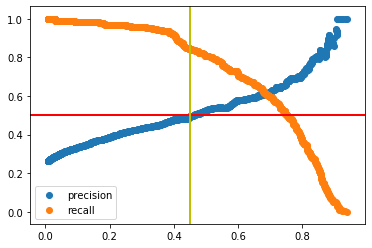

In [75]:
import matplotlib.pyplot as plt
plt.scatter(x = thresholds, 
            y = precision[1:], 
            label = 'precision')
plt.scatter(x = thresholds,
            y = recall[1:], label= 'recall')
plt.axhline(linewidth=2, color='r', y = .5)
plt.axvline(linewidth=2, color='y', x = .45)
plt.legend()

Let's say that we wanted to have recall as much as possible, so long as precision does not drop below 50 percent.  We can see from the plot above, that we can still maintain a precision of .5 (the red line), if set a threshold at .45 (the yellow line) and have a recall of around .8 or so.

### Solving with Code

Of course, to find the exact number we can loop through some different thresholds calculating the precision and accuracy for each one.

In [79]:
df = pd.DataFrame({'thresholds':thresholds, 'precision':precision[1:], 'recalls': recall[1:]})

In [80]:
df[:3]

,thresholds,precision,recalls
0,0.009261,0.263350,0.99723
1,0.009332,0.263543,0.99723
2,0.009370,0.263736,0.99723


We find where the precision is .5 (or thereabouts).

In [81]:
df[(df['precision'] < .5001) & (df['precision'] > .4999)]

,thresholds,precision,recalls
761,0.462763,0.5,0.836565


So we can see that we can have a recall score of .83 if we allow precision to drop to .5.  And we can do so with a threshold of .46.

So let's do this:

In [85]:
threshold = .46

threshold_preds = (model.predict_proba(X_validate) > threshold)[:, 1]
threshold_preds[:3]

recall_score(y_validate, threshold_preds), precision_score(y_validate, threshold_preds)

(0.8365650969529086, 0.49834983498349833)

And these are the related predictions.

In [86]:
threshold_preds.astype('int')[:5]

array([1, 1, 1, 0, 0])

### Wrapping Up

Finally, because precision and recall occur in tradeoffs, data scientists often use an average of precision and recall to summarize how well a model is performing on both of these metrics.  Except, the kind of average they use is called a harmonic mean.  The harmonic mean of precision and recall is the following: 

$F_1 = \frac{p*r}{p + r}$

In [87]:
from sklearn.metrics import f1_score

f1_score(y_validate, threshold_preds)

0.6246122026887281

> To find exactly where the harmonic mean peaks, we can again loop through various thresholds.

In [89]:
from sklearn.metrics import f1_score

In [90]:
import numpy as np 
thresholds = np.linspace(.30, .70, 100)

In [91]:
thresholds_and_f1_scores = []
for threshold in thresholds:
    threshold_preds = (model.predict_proba(X_validate) > threshold)[:, 1]
    score = f1_score(y_validate, threshold_preds)
    thresholds_and_f1_scores.append((threshold, score))

In [92]:
df = pd.DataFrame(thresholds_and_f1_scores, columns = ['threshold', 'f1'])

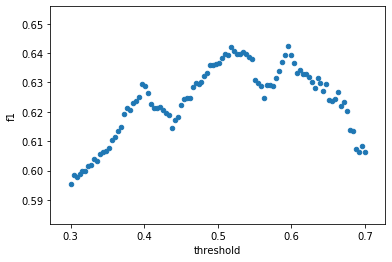

In [93]:
df.plot.scatter(x = 'threshold', y = 'f1')

So if our goal is to maximize the f1 score, we can see that this peaks right around .55.

### Summary

In this lesson, we saw how to balance precision and recall.  We saw that we can change the threshold from where we classify an observation as positive or negative with the following code:

```python
model.predict_proba(X_validate) > threshold
```

Then we saw how to plot the various tradeoffs with the precision_recall_curve.  The method takes in the true labels and the models predictions, and returns the precision and recall scores at various thresholds.

```python
y_val_preds = model.predict_proba(X_validate)
precision, recall, thresholds = precision_recall_curve(y_validate, y_val_preds[:, 1])
```

We then plot the threshold against the precision score, and the threshold against the recall score to better see the tradeoffs for our model.  